In [8]:
import sys,os,pickle,copy
sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
import numpy as np
import numpy
import pandas as pd
import scipy
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload
import seaborn as sns

import preprocess as prep

from sklearn.decomposition import NMF
from scipy.interpolate import interp1d

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
import matplotlib.pyplot as plt
%matplotlib inline

import nmf_analysis as na
import nmf_plot as nmfp
reload(na)
import data_prep_pyn as dpp

import pynapple as nap
from sklearn.cluster import KMeans
import database
db = database.db

In [2]:
import ruptures as rpt

import nmf_test as nt

import trial_correlates as tc
reload(tc)

<module 'trial_correlates' from '/mnt/home/szheng/projects/util_code/trial_correlates.py'>

In [3]:
data_dir_full=db.query('owner=="roman"')['data_dir_full'][0]
data_dir_full
db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
...                                                          ...   
e16_2m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   
e16_1f1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e14_2m3     0  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
...                        ...           ...         ...   
e16_2m1     0   e16_2m1_201116       e16_2m1  2020-11-16   
e16_1f1     0   e16_1f1_200823       e16_1f1  2020-08-23   
            1   e16_1f1_200824       e16_1f1  2020-08-24   
e14_2m3     0   e14_2m3_201017       e14_2m3  2020-10-17   
            1   e14_2m3_201019       e14_2m3  2020-10-19   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
...                                      ...          ...      ...   
e16_2m1     0                    alternation     0.636364       11   
e16_1f1     0                    alternation     0.631579       19   
            1                    alternation     0.571429       21   
e14_2m3     0                    alternation     0.615385       26   
            1                    alternation     0.863636       22   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
...                    ...        ...             ...    ...         ...  
e16_2m1     0           11         50              37  roman  roman_data  
e16_1f1     0           19         47              32  roman  roman_data  
            1           21         40              27  roman  roman_data  
e14_2m3     0           26         34              26  roman  roman_data  
            1           22         36              22  roman  roman_data  

[67 rows x 12 columns]

In [234]:
data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/'
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/'



In [5]:
reload(dpp)

<module 'data_prep_pyn' from '/mnt/home/szheng/projects/util_code/data_prep_pyn.py'>

In [235]:
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses = '*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
behavior=mat_to_return['behavior']
ripples=mat_to_return['ripples']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']

load *SessionPulses.Events.mat failed


In [236]:
beh_df=pd.DataFrame(beh_df)

speed_thresh = 1

In [237]:
reload(dpp)

beh_df_d,beh_df = dpp.group_into_trialtype(beh_df)

In [240]:
import trial_correlates_one_session as tcos
reload(tc)
reload(tcos)

tcdf=tcos.trial_correlates_one_session(data_dir_full,speed_thresh = 1,doplots=True,force_reload=True)

<module 'sys' (built-in)>
load *SessionPulses.Events.mat failed
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/nmf/nmf_4.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/trial_correlates/trial_correlates.p saved!
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_figures/trial_correlates made!


In [243]:
tcdf['df_d'][(1,0)]

,0,1,2,3,speed_std,speed_mean,speed_cv,trial_dur,idle_dur,idle_ratio,mean_fr_pyr,frac_active_pyr,mean_fr_int,frac_active_int,mean_fr_ratio,frac_active_ratio,ripple_count,ripple_rate
1,2.318670,0.000000,0.000000,0.000000,8.225231,8.959551,0.918041,11.100000,1.500000,0.135135,0.028982,0.723270,0.672272,1.0,0.043110,0.723270,0,0.000000
3,1.372296,0.708308,0.000000,0.000000,7.473918,6.037431,1.237930,19.400000,6.600000,0.340206,0.027410,0.754717,0.627873,1.0,0.043656,0.754717,0,0.000000
5,1.379861,0.000000,0.337035,0.000000,4.044712,5.539391,0.730173,23.933334,1.433333,0.059889,0.027461,0.801887,0.636985,1.0,0.043111,0.801887,0,0.000000
7,0.608599,1.594987,0.000000,0.000000,4.918595,3.926022,1.252819,30.566667,7.766667,0.254089,0.026844,0.820755,0.610445,1.0,0.043975,0.820755,0,0.000000
9,0.279504,1.634926,0.069183,0.000000,3.568607,2.544007,1.402750,50.333334,24.866667,0.494040,0.025890,0.817610,0.531611,1.0,0.048702,0.817610,0,0.000000
11,0.000000,2.017012,0.000000,0.091376,6.626720,7.607658,0.871059,13.300000,3.833333,0.288221,0.030950,0.663522,0.716124,1.0,0.043219,0.663522,0,0.000000
13,0.000000,1.903419,0.000000,0.184091,5.281148,4.074283,1.296215,27.233334,10.666667,0.391677,0.027682,0.776730,0.625459,1.0,0.044259,0.776730,0,0.000000
15,0.000000,1.740994,0.314931,0.018276,6.586697,7.018019,0.938541,15.166667,5.266667,0.347253,0.032207,0.713836,0.689426,1.0,0.046715,0.713836,0,0.000000
17,0.324067,0.676939,0.735843,0.000000,3.838847,3.768031,1.018794,32.666667,12.366667,0.378571,0.025651,0.764151,0.574240,1.0,0.044670,0.764151,0,0.000000
19,0.000000,1.142301,0.511205,0.220150,7.247110,6.160531,1.176378,18.266667,8.833334,0.483577,0.025995,0.729560,0.589376,1.0,0.044106,0.729560,0,0.000000


In [239]:
tc.get_reward_related_per_trial(beh_df)

correct  correct_prev
         trial                       
(0, 0.0) 1.0        1.0           NaN
         3.0        1.0           1.0
         4.0        0.0           1.0
         6.0        1.0           1.0
         7.0        0.0           1.0
         9.0        1.0           1.0
         10.0       0.0           1.0
         12.0       1.0           1.0
         14.0       1.0           1.0
         16.0       1.0           1.0
         18.0       1.0           1.0
         20.0       1.0           1.0
         22.0       1.0           1.0
         23.0       0.0           1.0
         24.0       0.0           0.0
         25.0       0.0           0.0
         26.0       0.0           0.0
(0, 1.0) 0.0        NaN           NaN
         2.0        1.0           1.0
         5.0        1.0           0.0
         8.0        1.0           0.0
         11.0       1.0           0.0
         13.0       1.0           1.0
         15.0       1.0           1.0
         17.0       1.0           1.0
         19.0       1.0           1.0
         21.0       1.0           1.0
         27.0       1.0           0.0

In [41]:
# interval=pd.IntervalIndex.from_tuples([tuple(beh_df.query('task_index==0').index[[0,-1]])])

# ripples_times_behavior = ripples['timestamps']

# ma = interval.contains(ripples['timestamps'][:,0])
# ripples_times_behavior=ripples['timestamps'][ma]

In [49]:
# ripples_times_behavior = nap.Ts(ripples_times_behavior[:,0])

In [141]:
key=(0,0)
ripple_times_ts = nap.Ts(ripples['timestamps'][:,0])
trial_intervals=beh_df_d[key].groupby('trial').apply(lambda x:pd.Series([x.index[0],x.index[-1]]))
trial_intervals = nap.IntervalSet(start=trial_intervals[0],end=trial_intervals[1])
ripple_times_one_trialtype=ripple_times_ts.restrict(trial_intervals)


In [143]:
task_index=key[0]
beh_df_one_task=beh_df.query('task_index==@task_index')
f=interp1d(beh_df_one_task.index,beh_df_one_task['lin'])
ripple_location=f(ripple_times_one_trialtype.times())
ripple_location_tsd = nap.Tsd(ripple_times_one_trialtype.times(),d=ripple_location)

In [144]:
ripple_location_tsd

Time (s)
7209.1080    123.165529
7400.0904    112.301325
7568.3056    114.381948
7568.6912    114.468641
7570.5752    114.815411
7787.8256    112.127940
7846.5448    145.689426
7851.1616    145.071134
7936.6312    106.046106
7942.9096    112.734788
8089.7632    111.954555
8095.0632    111.954555
8105.4272    114.593131
8130.2600    115.662311
8139.6400    115.335567
8352.1672    131.373701
8360.3904    132.655191
8364.4152    132.500705
8371.1424    132.847475
dtype: float64

In [182]:
start_time_of_trial

trial
4.0     6767.139833
6.0     6858.629700
11.0    7101.024533
12.0    7180.911467
13.0    7250.429100
15.0    7386.697000
17.0    7480.254067
18.0    7516.996733
20.0    7610.253733
21.0    7666.434633
23.0    7773.495133
24.0    7816.105933
dtype: float64

In [190]:
ax.get_xticks()

array([6600., 6800., 7000., 7200., 7400., 7600., 7800., 8000.])

In [193]:
start_time_of_trial

trial
4.0     6767.139833
6.0     6858.629700
11.0    7101.024533
12.0    7180.911467
13.0    7250.429100
15.0    7386.697000
17.0    7480.254067
18.0    7516.996733
20.0    7610.253733
21.0    7666.434633
23.0    7773.495133
24.0    7816.105933
dtype: float64

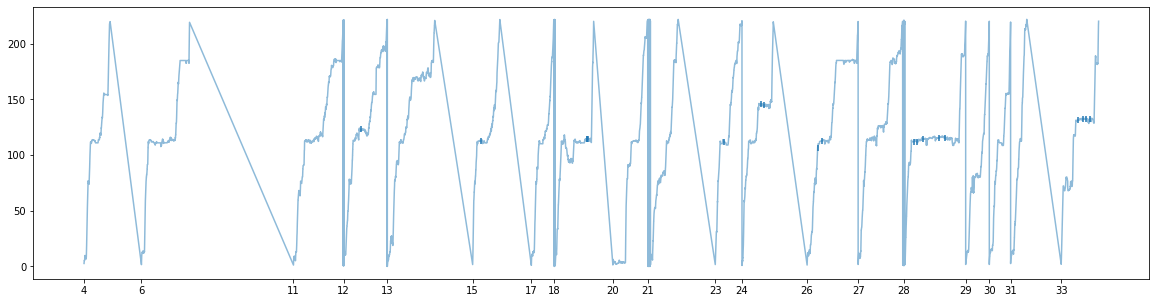

In [231]:
# starttime = beh_df_d[key].query('trial==40').index[0]
# endtime = beh_df_d[key].query('trial<=45').index[-1]

# ax=beh_df.loc[starttime:endtime,'lin'].plot(alpha=0.5)
beh_df_sub=beh_df_d[key].query('trial>=4&trial<=33')
start_time_of_trial=beh_df_sub.groupby('trial').apply(lambda x:x.index[0])
fig,ax=plt.subplots(figsize=(20,5))
# ax = beh_df_sub['lin'].plot(alpha=0.5)
ax.plot(beh_df_sub.index,beh_df_sub['lin'],alpha=0.5)

ax.set_xticks(start_time_of_trial.values)
ax.set_xticklabels(start_time_of_trial.index.astype(int))

# ax2 = ax.twiny()
# ax2.spines['bottom'].set_position(("axes",-0.1))
# ax2.xaxis.set_ticks_position("bottom")
# ax2.xaxis.set_label_position("bottom")
# ax2.set_xticks(start_time_of_trial.values)
# ax2.set_xticklabels(start_time_of_trial.index.astype(int))

curr_interval=nap.IntervalSet(start=beh_df_sub.index[0],end=beh_df_sub.index[-1])
ripple_location_tsd_restricted=ripple_location_tsd.restrict(curr_interval)
ax.scatter(ripple_location_tsd_restricted.times(),ripple_location_tsd_restricted.values,marker='|')




In [232]:
spk_one_restricted=prep_res['spike_trains'][123].restrict(curr_interval)
spk_one_restricted_location = f(spk_one_restricted.index)
ax.scatter(spk_one_restricted.times(),spk_one_restricted_location,marker='|',c='C1')

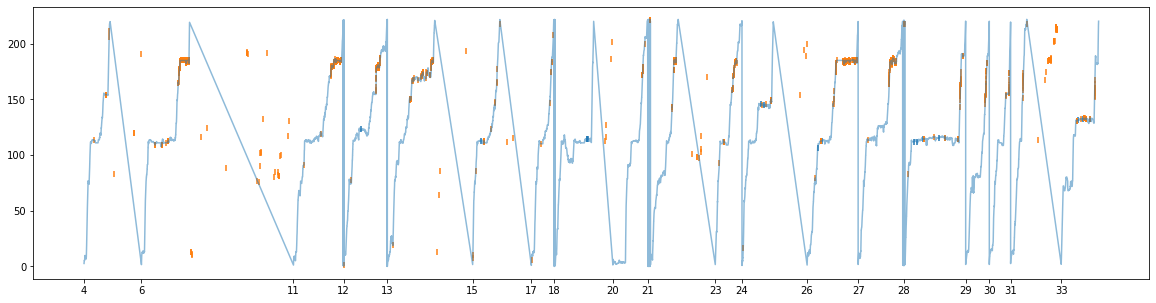

In [233]:
ax.figure

In [217]:
pd.Series(X_normed_restacked_df.columns)

0      0.0
1      2.0
2      4.0
3      6.0
4     11.0
5     12.0
6     13.0
7     15.0
8     17.0
9     18.0
10    20.0
11    21.0
12    23.0
13    24.0
14    26.0
15    27.0
16    28.0
17    29.0
18    30.0
19    31.0
20    33.0
Name: trial, dtype: float64

In [210]:
spk_one_restricted_location

array([  5.04562348,   5.18866973,   5.25451216,  50.38666846,
        76.72139219, 111.00093594, 111.00093594, 115.78853565,
       115.68164435, 115.6723775 , 115.66120533, 116.06274439,
       116.13140494, 154.2605512 , 154.2605512 , 191.75042445,
        71.60416878, 113.17467139, 117.15960469, 117.97826379,
       116.62178183, 116.64259444, 116.65545717, 116.66626544,
       117.74896779, 117.83114633, 137.36177112,   6.37311779,
       111.00093594, 115.00769526, 115.02095923, 115.03283612,
       115.42728752, 115.44497281, 115.93808041, 115.94241504,
       115.94241504, 115.85572243, 185.03715897,  12.67788828,
        71.66358041,  71.93184508,  72.53331285, 108.76136543,
       111.31045733, 141.88409224,   9.10799404,   7.9550037 ,
         7.211557  ,  45.7316785 ,  76.84886366,  75.12158429,
       180.14624475, 193.72135994, 191.83961283, 194.76879288,
       197.73666051, 197.86690248, 197.9542238 , 204.36677941,
       204.22600228, 204.22600228, 204.22600228, 204.22

In [156]:
import nmf_one_session as nos
n_compo=4

nmf_res = nos.nmf_one_session(data_dir_full,kwargs_={'n_compo':n_compo,'dosave':False,'doplots':False,'force_reload':False})



/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/nmf/nmf_4.p already exists! Loading--


In [166]:
X_normed_restacked_df=nmf_res['X_normed_restacked_df_d'][key]

import nmf_cpd as nc
reload(nc)
X = X_normed_restacked_df.values
n_compo = 4
n_bkps = 2
%time w_,h_,bkps_l,err_tot_l = nc.nmf_pwc_h_fit(X,n_compo,n_bkps=n_bkps,max_iters_outer=50,max_iters_rank1=4,tol=1e-8,w_init=None,h_init=None)



CPU times: user 55.3 s, sys: 21.7 s, total: 1min 16s
Wall time: 19.2 s


(<Figure size 666x4795.2 with 4 Axes>,
 {'W': <AxesSubplot:label='W', xlabel='component', ylabel='neuron'>,
  'H': <AxesSubplot:label='H', ylabel='component'>})

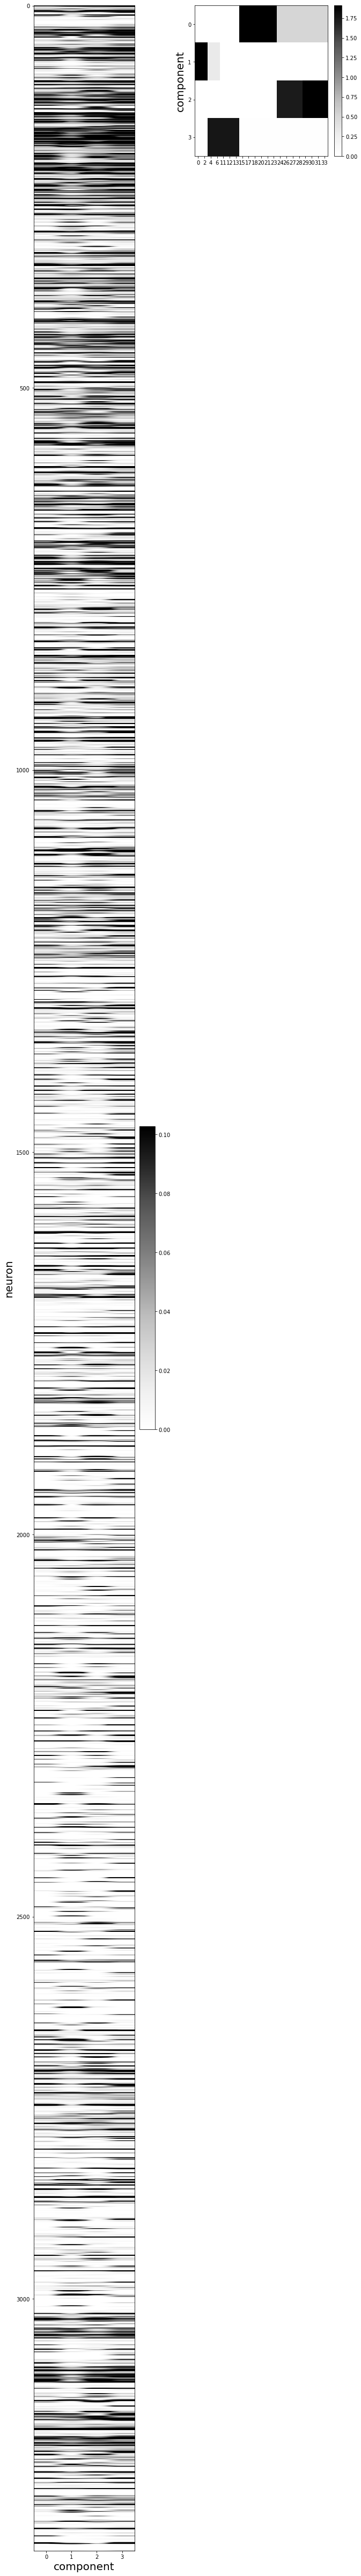

In [179]:
nmfp.plot_wh(w_,h_,trial_ticklabels=X_normed_restacked_df.columns.astype(int),spacing=1)

In [178]:
trial_inds = X_normed_restacked_df.columns
[trial_inds[bkps[:-1]] for bkps in bkps_l]

[Float64Index([0.0, 15.0, 24.0], dtype='float64', name='trial'),
 Float64Index([0.0, 4.0, 11.0], dtype='float64', name='trial'),
 Float64Index([0.0, 24.0, 29.0], dtype='float64', name='trial'),
 Float64Index([0.0, 4.0, 15.0], dtype='float64', name='trial')]

In [170]:
bkps_l

array([array([ 0,  7, 13, 21]), array([ 0,  2,  4, 21]),
       array([ 0, 13, 17, 21]), array([ 0,  2,  7, 21])], dtype=object)

<AxesSubplot:xlabel='Time (s)'>

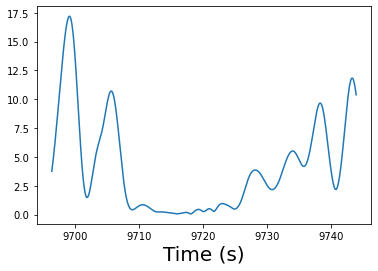

In [77]:
beh_df_d[key].query('trial==1')['speed'].plot()

<AxesSubplot:xlabel='Time (s)'>

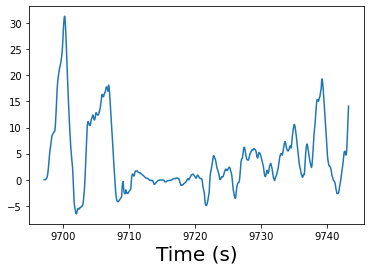

In [78]:
beh_df_d[key].query('trial==1')['v'].plot()

In [51]:
speed_stats.loc[(0,1)]

,var,mean,cv
trial,,,
1.0,17.526055,4.110027,1.018585
3.0,9.096027,2.570801,1.173160
5.0,17.571438,4.052851,1.034292
7.0,26.011894,6.493275,0.785457
10.0,11.468976,4.312348,0.785323
13.0,16.309162,4.394438,0.918994
15.0,21.003992,4.243955,1.079892
19.0,20.019749,3.799199,1.177707
21.0,24.508652,5.385994,0.919166


In [45]:
speed_stats[key]

KeyError: (0, 1)

In [340]:
key=(0,1)
df=nmf_res['H_sorted_d'][key].T
df=pd.concat([df,speed_stats.loc[key]],axis=1)
# df=pd.concat([df,v_stats.loc[key]],axis=1)
df=pd.concat([df,time_related.loc[key]],axis=1)
df=pd.concat([df,firing_related.loc[key]],axis=1)
df=pd.concat([df,reward_related.loc[key]],axis=1)
df=pd.concat([df,ripples_related.loc[key]],axis=1)
# df['v_var']=v_var[key]

<AxesSubplot:xlabel='trial'>

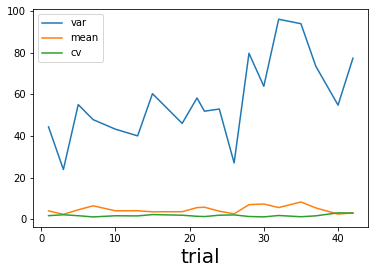

In [84]:
df[speed_stats.columns].plot()

<AxesSubplot:xlabel='trial'>

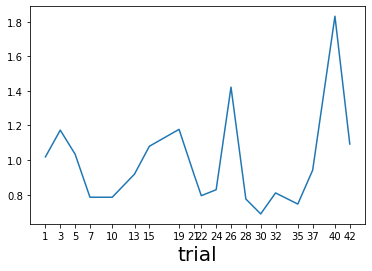

In [102]:
df['cv'].plot(xticks=df.index)

In [111]:
np.median(np.diff(beh_df.index))

0.03336666600080207

<AxesSubplot:xlabel='trial'>

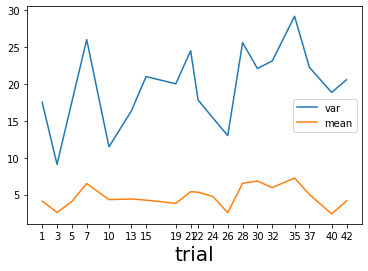

In [105]:
df[['var','mean']].plot(xticks=df.index)

<AxesSubplot:xlabel='trial'>

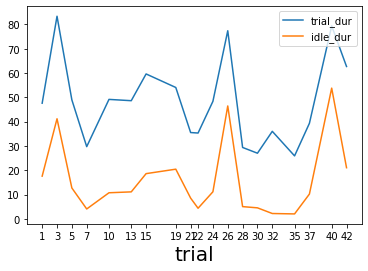

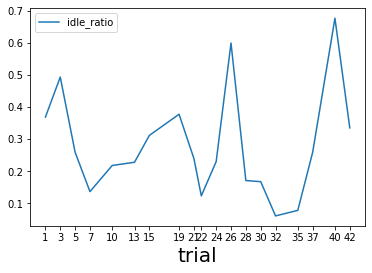

In [130]:
df[['trial_dur','idle_dur']].plot(xticks=df.index)
df[['idle_ratio']].plot(xticks=df.index)

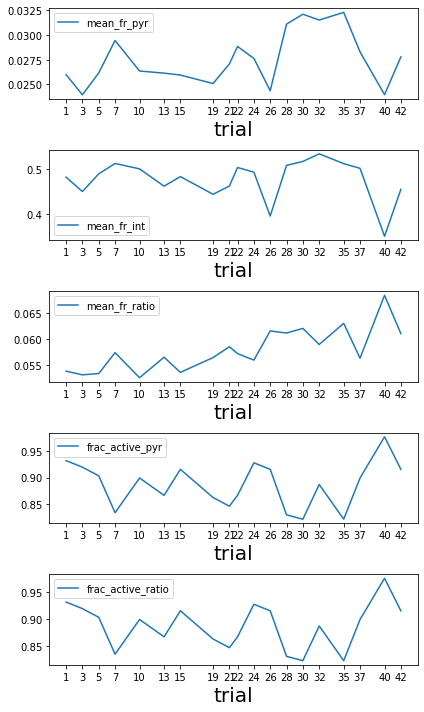

In [41]:
fig,axs=plt.subplots(5,1,figsize=(6,10))
df[['mean_fr_pyr']].plot(ax=axs[0],xticks=df.index)
df[['mean_fr_int']].plot(ax=axs[1],xticks=df.index)
df[['mean_fr_ratio']].plot(ax=axs[2],xticks=df.index)
df[['frac_active_pyr']].plot(ax=axs[3],xticks=df.index)
df[['frac_active_ratio']].plot(ax=axs[4],xticks=df.index)
plt.tight_layout()

<AxesSubplot:xlabel='trial'>

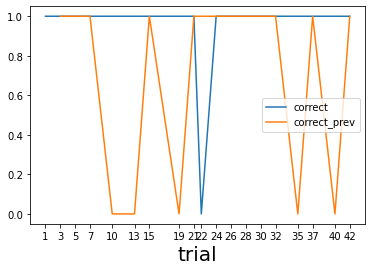

In [110]:
df[reward_related.columns].plot(xticks=df.index)

In [311]:
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

<AxesSubplot:>

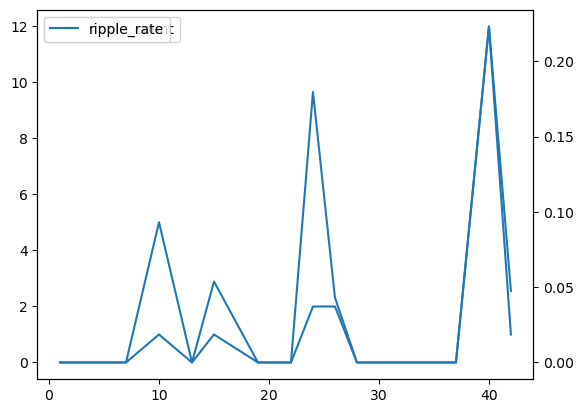

In [312]:
# ph.plot_using_two_axis(df,left_cols=['ripple_count'],right_cols=['ripple_rate'])

<AxesSubplot:>

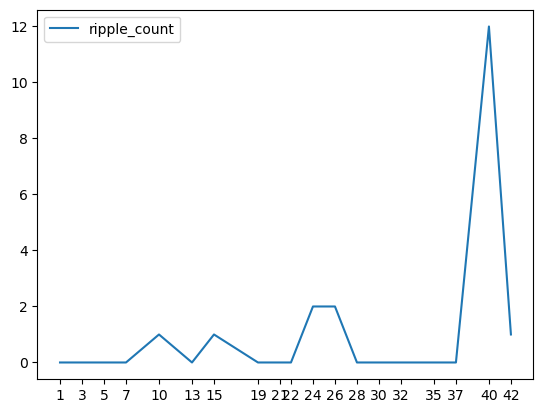

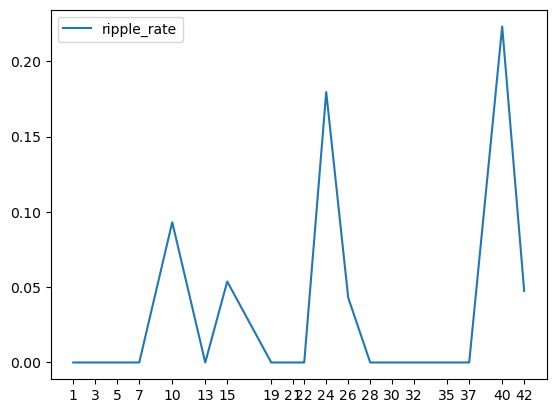

In [315]:
df[['ripple_count']].plot(xticks=df.index)
df[['ripple_rate']].plot(xticks=df.index)

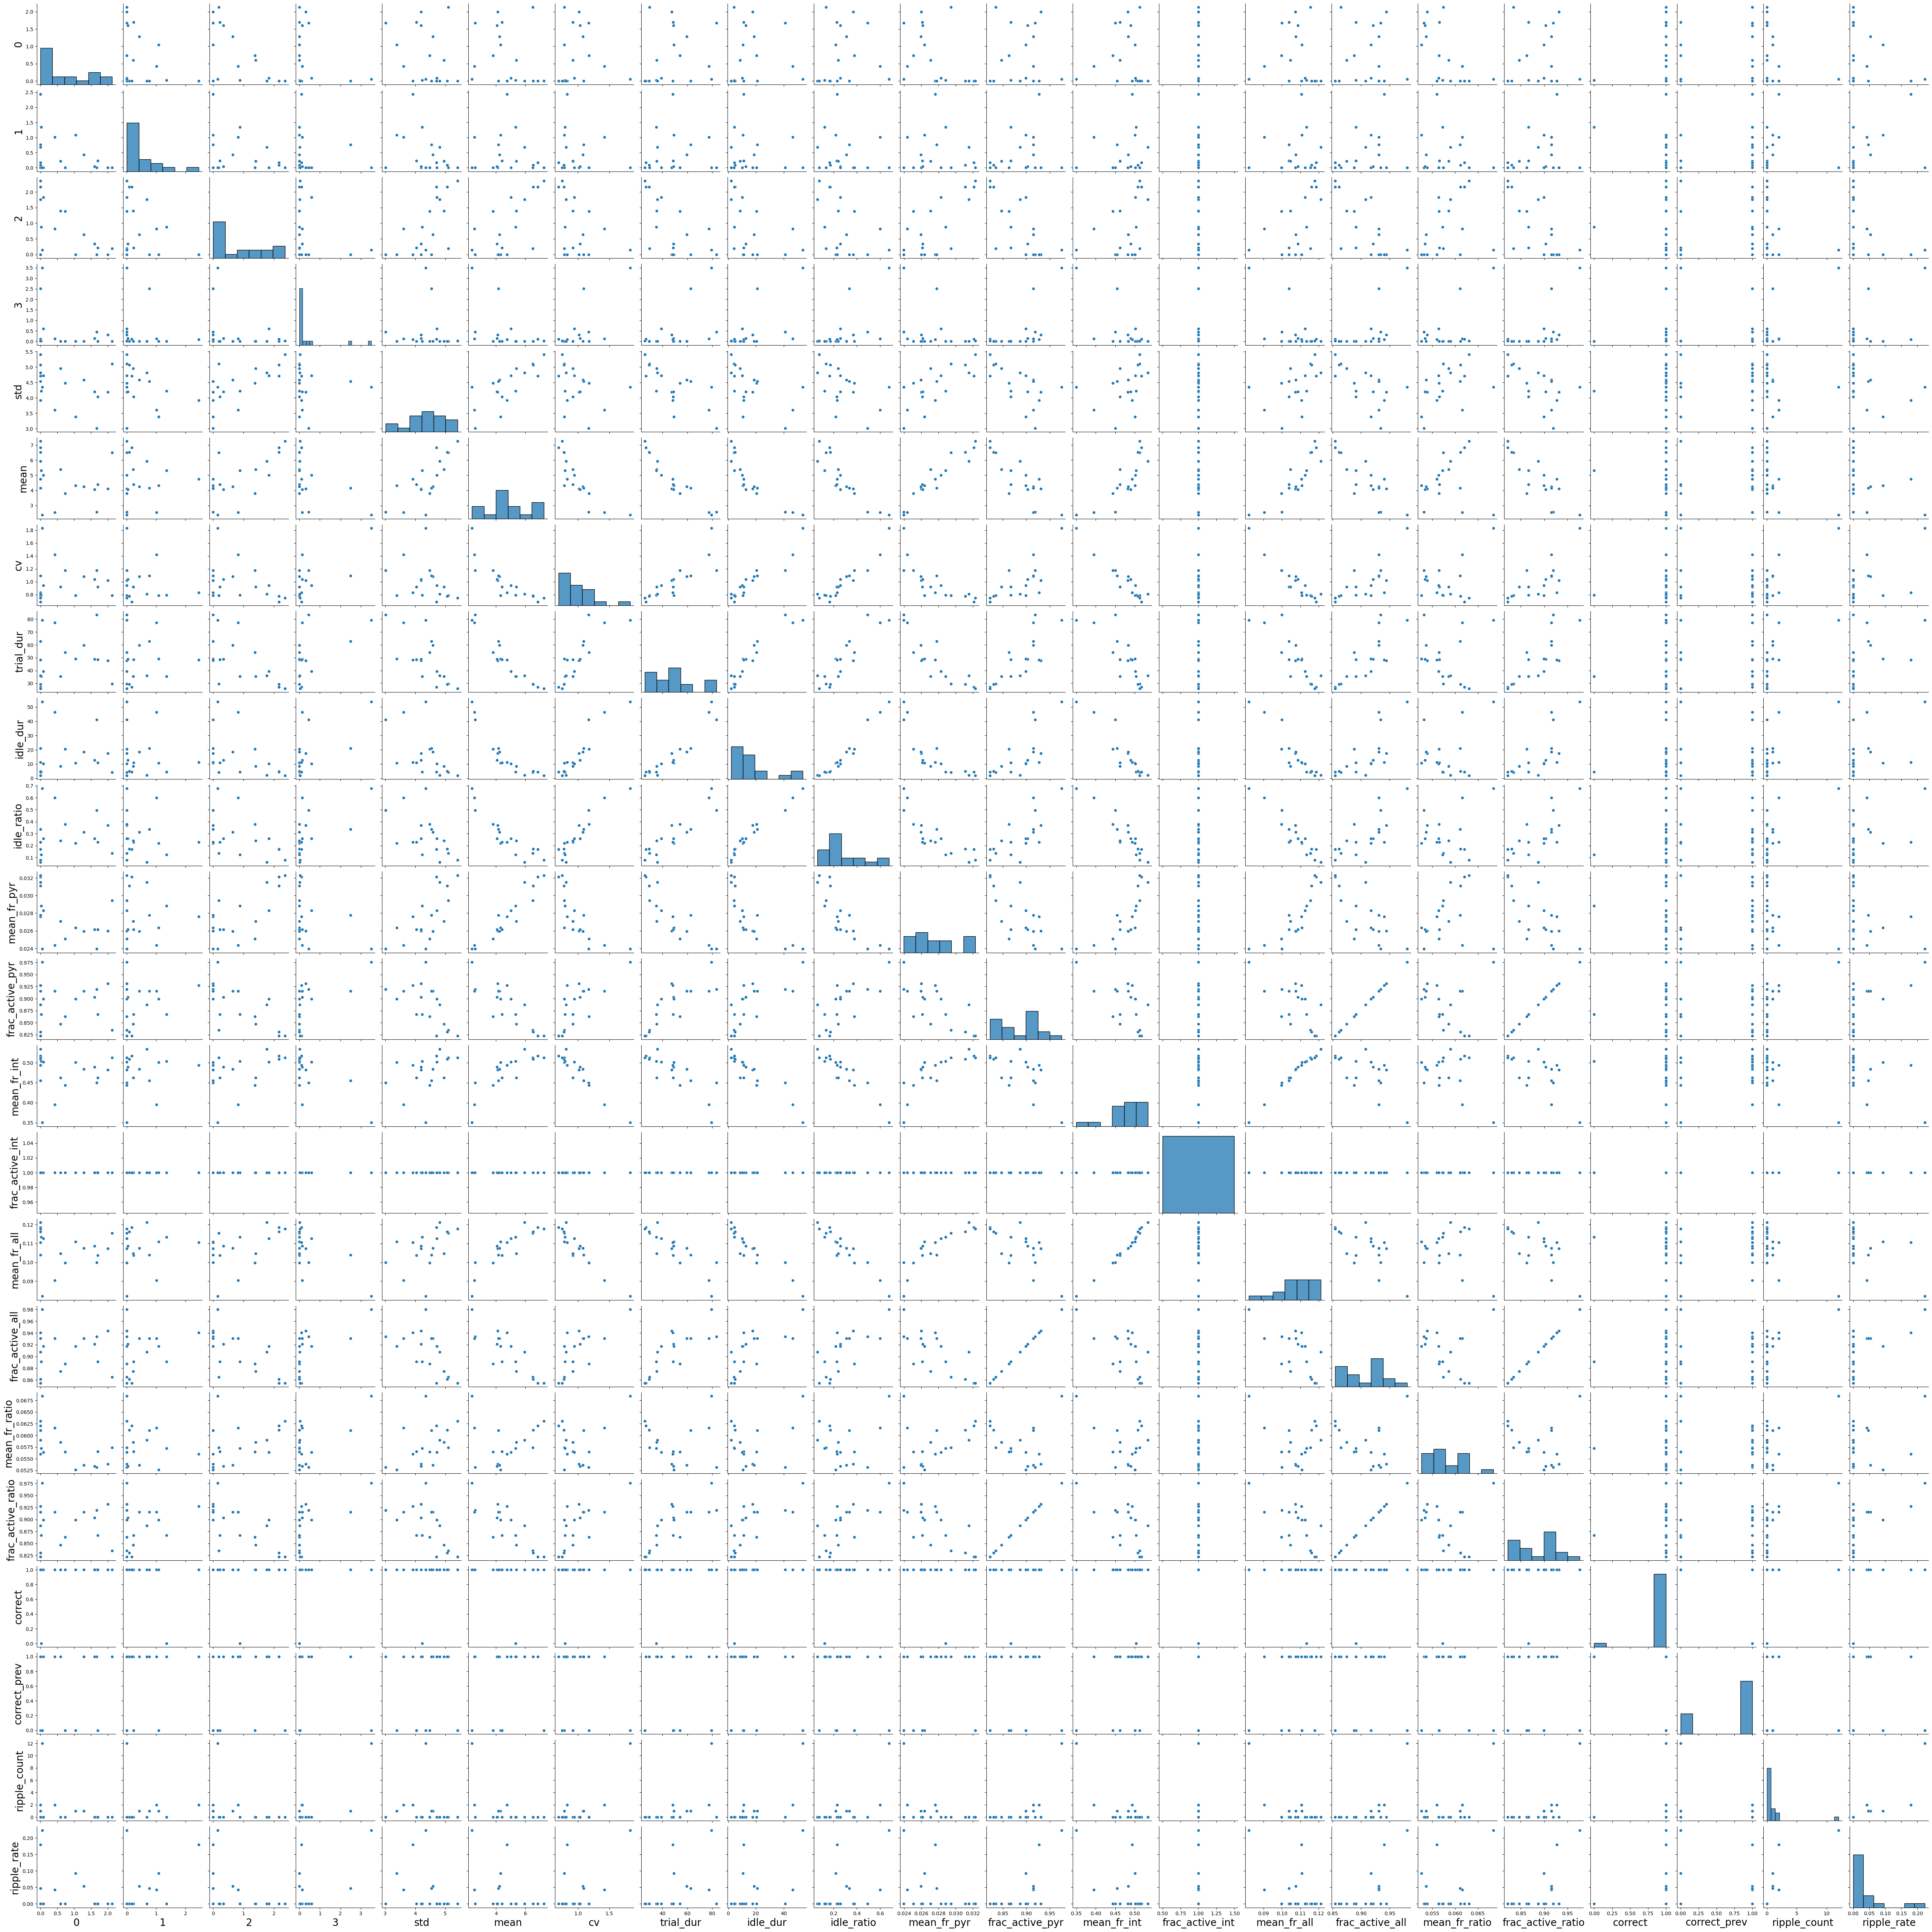

In [317]:
sns.pairplot(df)

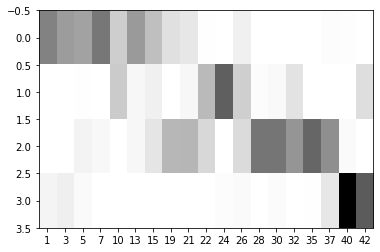

In [99]:
fig,ax=plt.subplots()
ax.imshow(nmf_res['H_sorted_d'][key],aspect='auto')
_=ax.set_xticks(np.arange(0,nmf_res['H_sorted_d'][key].shape[1],1))
_=ax.set_xticklabels(df.index[::1].astype(int))

In [323]:
corr.round(1)

,0,1,2,3,std,mean,cv,trial_dur,idle_dur,idle_ratio,...,mean_fr_int,frac_active_int,mean_fr_all,frac_active_all,mean_fr_ratio,frac_active_ratio,correct,correct_prev,ripple_count,ripple_rate
0,1.0,-0.4,-0.6,-0.3,-0.3,-0.3,0.0,0.2,0.1,0.1,...,0.0,NaN,-0.1,0.1,-0.6,0.1,0.2,-0.1,-0.2,-0.3
1,-0.4,1.0,-0.3,-0.1,-0.4,-0.1,-0.2,0.1,-0.1,-0.1,...,0.1,NaN,0.1,0.2,-0.1,0.2,-0.3,0.2,0.0,0.5
2,-0.6,-0.3,1.0,-0.3,0.7,0.7,-0.4,-0.6,-0.4,-0.4,...,0.4,NaN,0.5,-0.7,0.4,-0.7,-0.0,0.1,-0.3,-0.4
3,-0.3,-0.1,-0.3,1.0,-0.0,-0.4,0.7,0.5,0.6,0.6,...,-0.7,NaN,-0.6,0.6,0.6,0.6,0.1,-0.2,0.8,0.6
std,-0.3,-0.4,0.7,-0.0,1.0,0.8,-0.3,-0.7,-0.6,-0.5,...,0.4,NaN,0.5,-0.6,0.4,-0.6,0.1,0.1,-0.1,-0.3
mean,-0.3,-0.1,0.7,-0.4,0.8,1.0,-0.8,-1.0,-0.9,-0.9,...,0.8,NaN,0.9,-0.8,0.1,-0.8,-0.1,0.2,-0.5,-0.4
cv,0.0,-0.2,-0.4,0.7,-0.3,-0.8,1.0,0.8,0.9,0.9,...,-0.9,NaN,-0.9,0.7,0.4,0.7,0.2,-0.2,0.8,0.5
trial_dur,0.2,0.1,-0.6,0.5,-0.7,-1.0,0.8,1.0,0.9,0.9,...,-0.8,NaN,-0.9,0.8,-0.0,0.8,0.2,-0.1,0.5,0.5
idle_dur,0.1,-0.1,-0.4,0.6,-0.6,-0.9,0.9,0.9,1.0,1.0,...,-0.9,NaN,-0.9,0.7,0.3,0.7,0.2,-0.1,0.7,0.5
idle_ratio,0.1,-0.1,-0.4,0.6,-0.5,-0.9,0.9,0.9,1.0,1.0,...,-0.9,NaN,-0.9,0.7,0.2,0.7,0.2,-0.2,0.6,0.5


<AxesSubplot:>

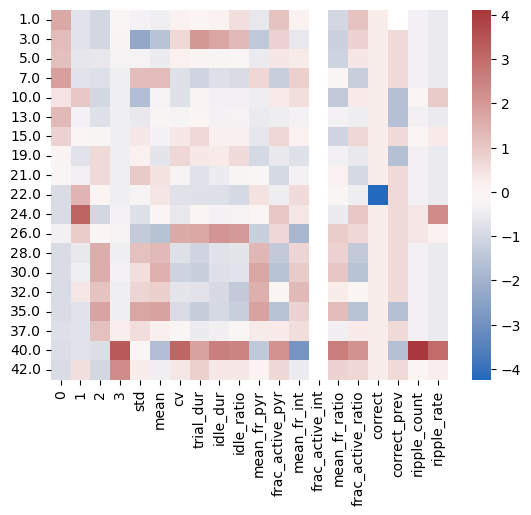

In [346]:
df_z=df.apply(lambda x:scipy.stats.zscore(x,nan_policy='omit'))
sns.heatmap(df_z,cmap='vlag')

In [366]:
from sklearn.cluster import KMeans,AgglomerativeClustering

In [358]:
df_z=df_z.dropna(axis=1,how='all').fillna(0) # drop columns that don't change; fill the rest na with 0

In [385]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :], idx
    return corr_array[idx, :][:, idx], idx

In [386]:
corr_sorted,idx = cluster_corr(df_z.corr())

<AxesSubplot:>

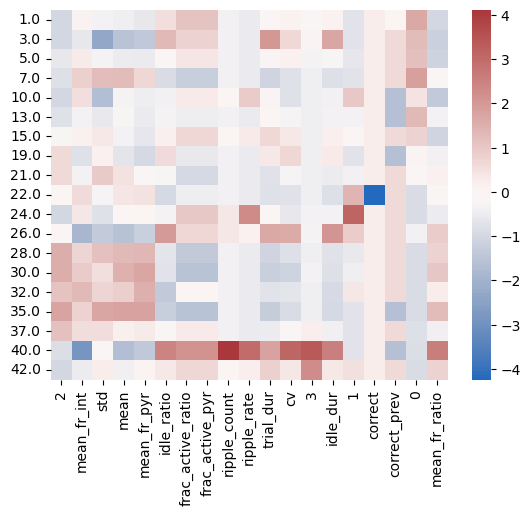

In [388]:
df_z_sorted=df_z.iloc[:,idx]
sns.heatmap(df_z_sorted,cmap='vlag')

<AxesSubplot:>

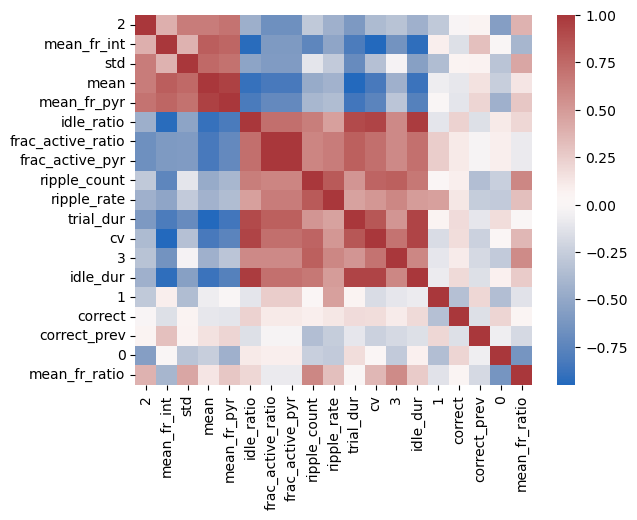

In [378]:
sns.heatmap(corr_sorted,cmap='vlag')

In [7]:
fn='/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/trial_correlates/trial_correlates.p'
pickle.load(open(fn,'rb'))

EOFError: Ran out of input

<module 'sys' (built-in)>
load *SessionPulses.Events.mat failed
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/nmf/nmf_4.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/trial_correlates/trial_correlates.p saved!


In [370]:
model=AgglomerativeClustering(n_clusters=4,affinity='cosine',linkage='complete')
labels=model.fit_predict(df_z)
labels_series=pd.Series(labels,index=df_z.columns)

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<AxesSubplot:>

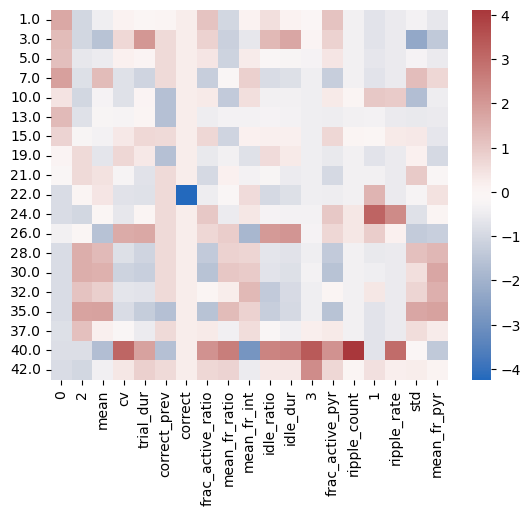

In [372]:
labels_series_sorted=labels_series.sort_values()
df_z[labels_series_sorted.index]
sns.heatmap(df_z[labels_series_sorted.index],cmap='vlag')

<AxesSubplot:>

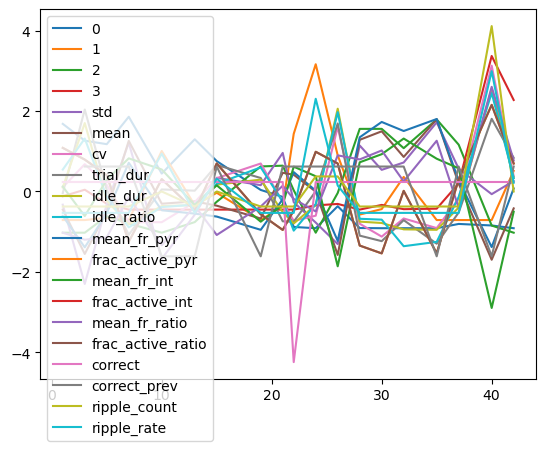

In [347]:
df_z.plot()

<AxesSubplot:>

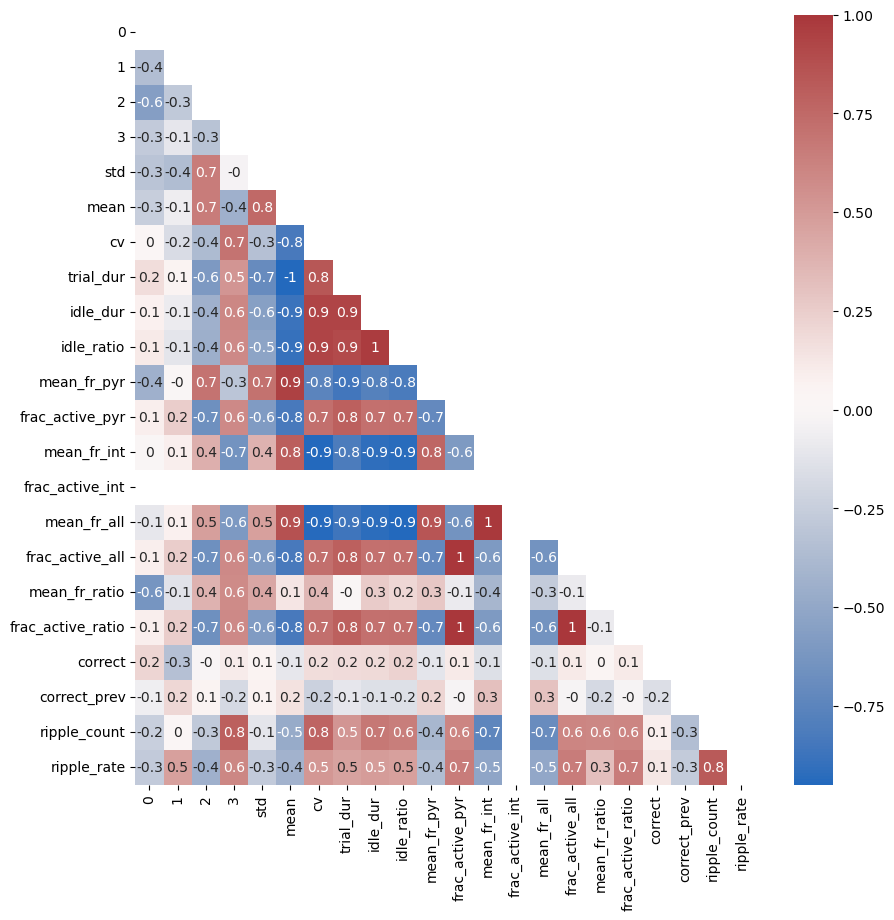

In [329]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
# corr
fig,ax=plt.subplots(figsize=(10,10,))
sns.heatmap(corr,mask=mask,annot=corr.round(1),cmap='vlag',ax=ax)

In [298]:
df.corr()

,0,1,2,3,ripple_count,ripple_rate
0,1.000000,-0.353141,-0.565375,-0.272419,-0.244323,-0.274267
1,-0.353141,1.000000,-0.287054,-0.109227,0.021282,0.469367
2,-0.565375,-0.287054,1.000000,-0.320142,-0.287119,-0.442809
3,-0.272419,-0.109227,-0.320142,1.000000,0.796449,0.596889
ripple_count,-0.244323,0.021282,-0.287119,0.796449,1.000000,0.831888
ripple_rate,-0.274267,0.469367,-0.442809,0.596889,0.831888,1.000000
